# Survival Analysis of GSL Genes in Glioma

### This analysis is done using TCGA TPM data for LGG accessed from the Xena databse

1. Installing and Importing Packages

In [ ]:
# %%capture
# %pip install scipy
# %pip install numpy
# %pip install pandas
# %pip install requests
# %pip install aiohttp
# %pip install pronto
# %pip install matplotlib
# %pip install plotly
# %pip install umap-learn
# %pip install scikit-learn
# %pip install plotly
# %pip install nbformat
# %pip install seaborn
# %pip install hdbscan
# %pip install lifelines
# %pip install scikit-survival

In [27]:
#Importing Packages
import requests
import time
import math

import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.express as px
import plotly
import plotly.tools as tls
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

import umap.umap_ as UMAP 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sksurv.util import Surv
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

from statsmodels.stats.multitest import multipletests


2. Loading in and cleaning Data

In [17]:
df = pd.read_csv("C:/Users/ottoc/OneDrive - University of Cambridge/PhD Year 3/GSL_Metabolism_Project/Xena_Data_TPM.tsv",sep='\t')
df.head()

,sample,samples,detailed_category,DFI,DFI.time,DSS,DSS.time,_gender,TCGA_GTEX_main_category,OS,...,ST3GAL6,ST6GALNAC2,ST6GALNAC3,ST6GALNAC4,ST6GALNAC5,ST6GALNAC6,ST8SIA1,ST8SIA5,UGCG,UGT8
0,TARGET-10-PASLZM-40,TARGET-10-PASLZM-40,Acute Lymphoblastic Leukemia,NaN,NaN,NaN,NaN,Female,NaN,NaN,...,-1.5100,-2.8260,0.7748,5.303,-1.884,4.150,-2.388,-4.2930,1.486,0.6517
1,TARGET-10-PAPEFH-09,TARGET-10-PAPEFH-09,Acute Lymphoblastic Leukemia,NaN,NaN,NaN,NaN,Female,NaN,NaN,...,0.8726,-1.7320,-1.2480,4.277,-1.283,3.126,-2.388,-5.0120,1.351,-3.0470
2,TARGET-10-PANJPG-09,TARGET-10-PANJPG-09,Acute Lymphoblastic Leukemia,NaN,NaN,NaN,NaN,Female,NaN,NaN,...,3.3510,1.5710,-3.6260,4.816,-6.506,4.530,1.215,4.0290,4.119,-9.9660
3,TARGET-10-PARPRW-09,TARGET-10-PARPRW-09,Acute Lymphoblastic Leukemia,NaN,NaN,NaN,NaN,Female,NaN,NaN,...,1.5850,-1.5950,0.2522,5.841,-9.966,4.372,-1.181,-4.0350,1.848,0.2400
4,TARGET-10-PARSZH-09,TARGET-10-PARSZH-09,Acute Lymphoblastic Leukemia,NaN,NaN,NaN,NaN,Female,NaN,NaN,...,1.0360,-0.1187,-1.5520,4.982,-9.966,4.286,-3.047,-0.2328,2.141,-9.9660


In [18]:
#Making a TCGA dataset with only "Primary Tumor" and "Solid Tissue Normal" Samples
df_TCGA = df[df["_study"]=="TCGA"]
df_TCGA = df_TCGA[df_TCGA["_sample_type"].isin(["Primary Tumor", "Solid Tissue Normal"])]

#Making a TCGA dataset which only has cancerous primary tumor data.
df_TCGA_cancer = df[df["_study"]=="TCGA"]
df_TCGA_cancer = df_TCGA_cancer[df_TCGA_cancer["_sample_type"]=="Primary Tumor"]

In [19]:
#Making a TCGA dataframe for simple initial visualisation.
df_TCGA_mini = df_TCGA.drop(columns=['sample',
 'samples',
 '_study',
 '_gender',
 'detailed_category',
 'TCGA_GTEX_main_category',
 '_primary_site',
 'DFI',
 'DFI.time',
 'DSS',
 'DSS.time',
 'OS',
 'OS.time',
 'PFI',
 'PFI.time'])

#Making a TCGA cancer dataframe for simple initial visualisation
df_cancer_mini = df_TCGA_cancer.drop(columns=['sample',
 'samples',
 '_study',
 '_gender',
 '_sample_type',
 'detailed_category',
 'TCGA_GTEX_main_category',
 '_primary_site',
 'DFI',
 'DFI.time',
 'DSS',
 'DSS.time',
 'OS',
 'OS.time',
 'PFI',
 'PFI.time'])

#Makign a TCGA cancer dataframe for KM analysis
df_KM = df_TCGA_cancer.drop(columns=['sample',
 'samples',
 '_study',
 '_gender',
 '_sample_type',
 'detailed_category',
 'TCGA_GTEX_main_category',
 '_primary_site'])

In [31]:
df_KM_LGG = df_KM[df_KM["primary disease or tissue"] == "Brain Lower Grade Glioma"]
df_KM_LGG = df_KM_LGG.drop(columns=["DFI", "DFI.time","OS","OS.time","PFI","PFI.time","primary disease or tissue"]).dropna().copy()
df_KM_LGG.head()

,DSS,DSS.time,A4GALT,ABO,B3GALNT1,B3GALT1,B3GALT4,B3GALT5,B3GNT2,B3GNT3,...,ST3GAL6,ST6GALNAC2,ST6GALNAC3,ST6GALNAC4,ST6GALNAC5,ST6GALNAC6,ST8SIA1,ST8SIA5,UGCG,UGT8
9272,1.0,1547.0,2.0150,-3.626,4.098,1.5410,1.0080,-0.1828,2.926,-4.608,...,2.674,0.4340,3.1290,3.994,2.025,5.208,5.364,1.2880,3.313,5.456
9273,1.0,1242.0,2.3480,-1.685,2.478,0.6425,2.3900,-0.5973,2.465,-9.966,...,5.379,-0.4325,1.5660,3.970,-1.355,6.092,4.213,-0.3752,2.644,5.311
9275,0.0,1989.0,0.4865,-2.466,3.798,1.4650,1.0430,-1.3180,1.820,-9.966,...,4.012,-1.0560,1.1380,3.487,2.499,6.442,3.603,1.2390,2.167,3.818
9276,0.0,1257.0,1.0570,-2.635,3.819,-0.1345,2.5190,-0.1345,3.312,-9.966,...,4.768,1.1450,2.7230,3.702,-2.635,5.585,3.776,-2.0530,3.738,5.238
9278,0.0,1341.0,0.6145,-3.816,1.669,-0.7346,0.6145,-0.1993,1.975,-9.966,...,4.626,0.5568,0.7748,4.095,-1.552,5.460,3.789,-0.9406,2.685,5.101


3. Lasso Regression to identify genes of interest

In [32]:
X = df_KM_LGG.drop(columns=["DSS","DSS.time"])
X = StandardScaler().fit_transform(X)

y = Surv.from_arrays(event=df_KM_LGG["DSS"].astype(bool), time=df_KM_LGG["DSS.time"].astype(float))

In [34]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(X, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

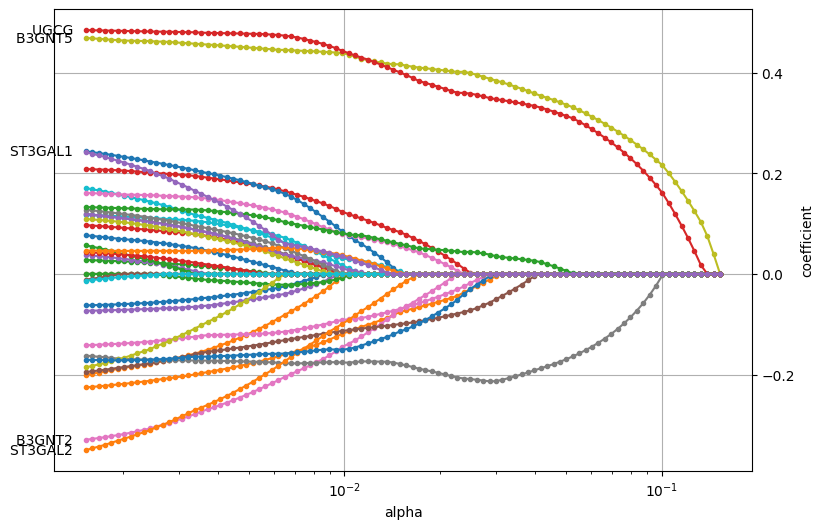

In [38]:
coefficients_lasso = pd.DataFrame(cox_lasso.coef_,index=df_KM_LGG.drop(columns=["DSS","DSS.time"]).columns, columns=np.round(cox_lasso.alphas_, 5))
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
plot_coefficients(coefficients_lasso, n_highlight=5)